In [1]:
import os
import sys
import json
import numpy as np
import torch
torch.set_default_dtype(torch.float64)
import sklearn
from sklearn.datasets import make_circles
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process as gp_sklearn
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
x, y = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
x = torch.from_numpy(x)
y = torch.from_numpy(y).double()
def scatterplot(x, y):
    colors = np.array(['0', '1'])
    sns.scatterplot(x[:, 0], x[:, 1], hue=colors[y.int()])
def meshgrid(x, n, eps=0.1):
    x0, x1 = np.meshgrid(np.linspace(x[:, 0].min()-eps, x[:, 0].max()+eps, n),
    np.linspace(x[:, 1].min()-eps, x[:, 1].max()+eps, n))
    x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    return x0, x1, x_grid
def plot_sklearn_predictions(sklearn_gp_classifier, x, y):
    x0, x1, x_grid = meshgrid(x, 30)
    preds = sklearn_gp_classifier.predict_proba(x_grid)
    preds_0 = preds[:,0].reshape(x0.shape)
    preds_1 = preds[:,1].reshape(x0.shape)
    plt.figure(figsize=(10,6))
    plt.contourf(x0, x1, preds_0, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.contourf(x0, x1, preds_1, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)
def get_logits(x, mu, sigma, l, eta):
    kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(sigma), lengthscale=torch.tensor(l))
    K = kernel.forward(x, x) + torch.eye(x.shape[0]) * 1e-6
    L = K.cholesky()
    return mu+torch.mv(L,eta)
def posterior_predictive(samples, i, x, x_grid):
    kernel = gp.kernels.RBF(input_dim=2, variance=samples['sigma'][i],
    lengthscale=samples['l'][i])
    N_grid = x_grid.shape[0]
    y = get_logits(x, samples['mu'][i], samples['sigma'][i],
    samples['l'][i], samples['eta'][i])
    with torch.no_grad():
        gpr = gp.models.GPRegression(x, y, kernel=kernel)
        mean, cov = gpr(x_grid, full_cov=True)
    yhat = dist.MultivariateNormal(mean, cov + torch.eye(N_grid) * 1e-6).sample()
    return yhat.sigmoid().numpy()
def plot_pyro_predictions(posterior_samples, x):
    n_samples = posterior_samples['sigma'].shape[0]
    x0, x1, x_grid = meshgrid(x, 30)
    x_grid = torch.from_numpy(x_grid)
    preds = np.stack([posterior_predictive(posterior_samples, i, x, x_grid) for i in range(n_samples)])
    plt.figure(figsize=np.array([10, 6]))
    plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101,
    cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

## Gaussian Classifier

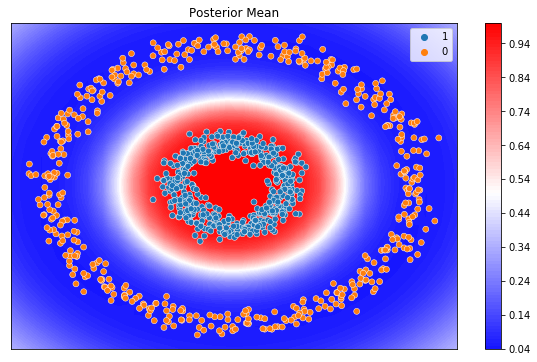

In [2]:
kernel=gp_sklearn.kernels.RBF(length_scale=1.0)
gc=gp_sklearn.GaussianProcessClassifier(kernel=kernel)
_=gc.fit(x,y)
plot_sklearn_predictions(gc,x,y)


## HMC

In [3]:
def gp_classifier(x,y):
    mu=pyro.sample("mu", dist.Normal(0,1))
    l=pyro.sample("l", dist.LogNormal(0,1))
    sigma=pyro.sample("sigma", dist.LogNormal(0,1))
    with pyro.plate('y',len(y)):
        eta=pyro.sample("eta",dist.Normal(0,1))
        lp=get_logits(x, mu, sigma, l, eta)
        yhat=pyro.sample("yhat",dist.Bernoulli(torch.sigmoid(lp)), obs=y)

HMC does 8% after 8 hours, so I use NUTS.

Sample: 100%|████| 60/60 [11:21, 11.35s/it, step size=1.55e-02, acc. prob=0.281]


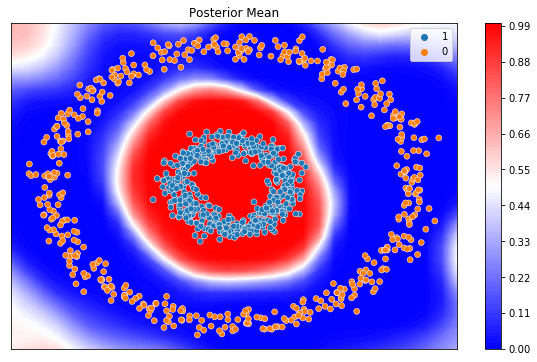

In [11]:
pyro.set_rng_seed(101)
kernel=NUTS(gp_classifier,jit_compile=True)
mcmc=MCMC(kernel, num_samples=10, warmup_steps=50)
mcmc.run(x=x,y=y)
samples=mcmc.get_samples()
plot_pyro_predictions(samples,x)